In [1]:
# Import basic packages
from pickletools import read_uint1
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, make_scorer
import shap
import matplotlib.pylab as pl
from IPython.display import display


In [3]:
# Reading data
data = pd.read_csv('ml_data.csv')
data.head(2)
y = data['y']
X = data.drop('y', axis = 1)
X = X.drop(['patient_no'], axis= 1)





# Training Model

In [4]:
xgb_final =XGBClassifier(base_score=0.47, booster='gbtree', colsample_bylevel=0.9357682105765912,
            colsample_bynode=0.76191611209093, colsample_bytree=0.9837861290482609, subsample=0.9175899249246555, enable_categorical=False,
            gamma=0.4602921444906467, gpu_id=-1, importance_type=None,
            interaction_constraints='', learning_rate=0.03772939172140023, max_delta_step=0,
            max_depth=7, min_child_weight=5,
            monotone_constraints='()', n_estimators=2800, n_jobs=16,
            num_parallel_tree=1, predictor='auto', random_state=23,
            reg_alpha=15, reg_lambda=8, scale_pos_weight=1,
            tree_method='exact', validate_parameters=1, verbosity=None)


In [5]:
# Fitting the entire dataset
xgb_final.fit(X, y)


XGBClassifier(base_score=0.47, booster='gbtree', callbacks=None,
              colsample_bylevel=0.9357682105765912,
              colsample_bynode=0.76191611209093,
              colsample_bytree=0.9837861290482609, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4602921444906467, gpu_id=-1, grow_policy=None,
              importance_type=None, interaction_constraints='',
              learning_rate=0.03772939172140023, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=7, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=2800, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=23, ...)

# SHAP

##### Creating disease-specific groups

In [6]:
#Leukemia dataset
al = X[(X['dx_ALL']==1 )| (X['dx_AML'] == 1)]

#Lymphoma dataset
lym = X[X['dx_OTHER_LYM'] == 1]

#MDS dataset
mds = X[X['dx_MDS'] == 1]

#Myleloma dataset
myle = X[X['dx_OTHER_MYLE'] == 1]

#others
other = X[X['dx_OTHER'] == 1]

#### Generating SHAP and SHAP interaction values 

In [7]:
explainer_new = shap.TreeExplainer(xgb_final)


#AL
shap_values_al = explainer_new.shap_values(al)
shap_interaction_values_al = shap.TreeExplainer(xgb_final).shap_interaction_values(al)

#LYM
shap_values_lym = explainer_new.shap_values(lym)
shap_interaction_values_lym = shap.TreeExplainer(xgb_final).shap_interaction_values(lym)

#MDS
shap_values_mds = explainer_new.shap_values(mds)
shap_interaction_values_mds = shap.TreeExplainer(xgb_final).shap_interaction_values(mds)

#MYLE
shap_values_myle = explainer_new.shap_values(myle)
shap_interaction_values_myle = shap.TreeExplainer(xgb_final).shap_interaction_values(myle)

#Others
shap_values_other = explainer_new.shap_values(other)
shap_interaction_values_other = shap.TreeExplainer(xgb_final).shap_interaction_values(other)



In [8]:
# Helper Function to visualise sepcific pair of interaction
def plot_shap_dependence_pairs(feature, feature2, shap_values, X_test, dpi = 800):
    num_features = X_test.shape[1]
    feature_names = X_test.columns

    for i in range(num_features):
        if feature_names[i] == feature:
            continue
        if feature_names[i] == feature2:
            plt.figure(dpi=dpi)  # Setting DPI for the new figure
            shap.dependence_plot(
                ind=feature,  # The feature of interest
                shap_values=shap_values,  # The SHAP values matrix
                features=X_test,  # The feature matrix
                interaction_index=feature_names[i],  # The feature to plot against
                feature_names=feature_names  # List of feature names
            )

            
            plt.show()


### AL Investigation

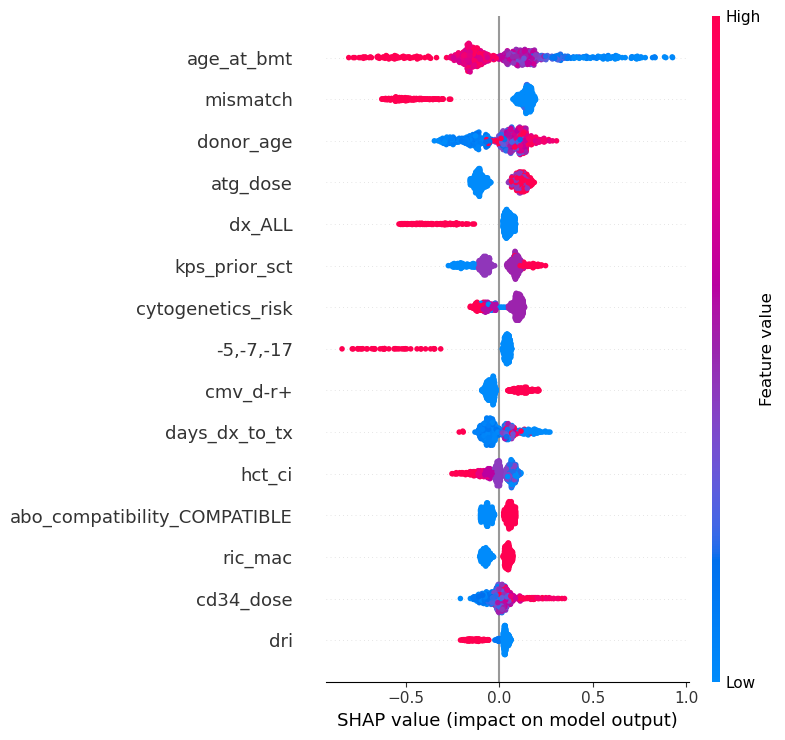

In [9]:
#Summary plot of top 15 features

shap.summary_plot(shap_values_al, al, max_display=15)

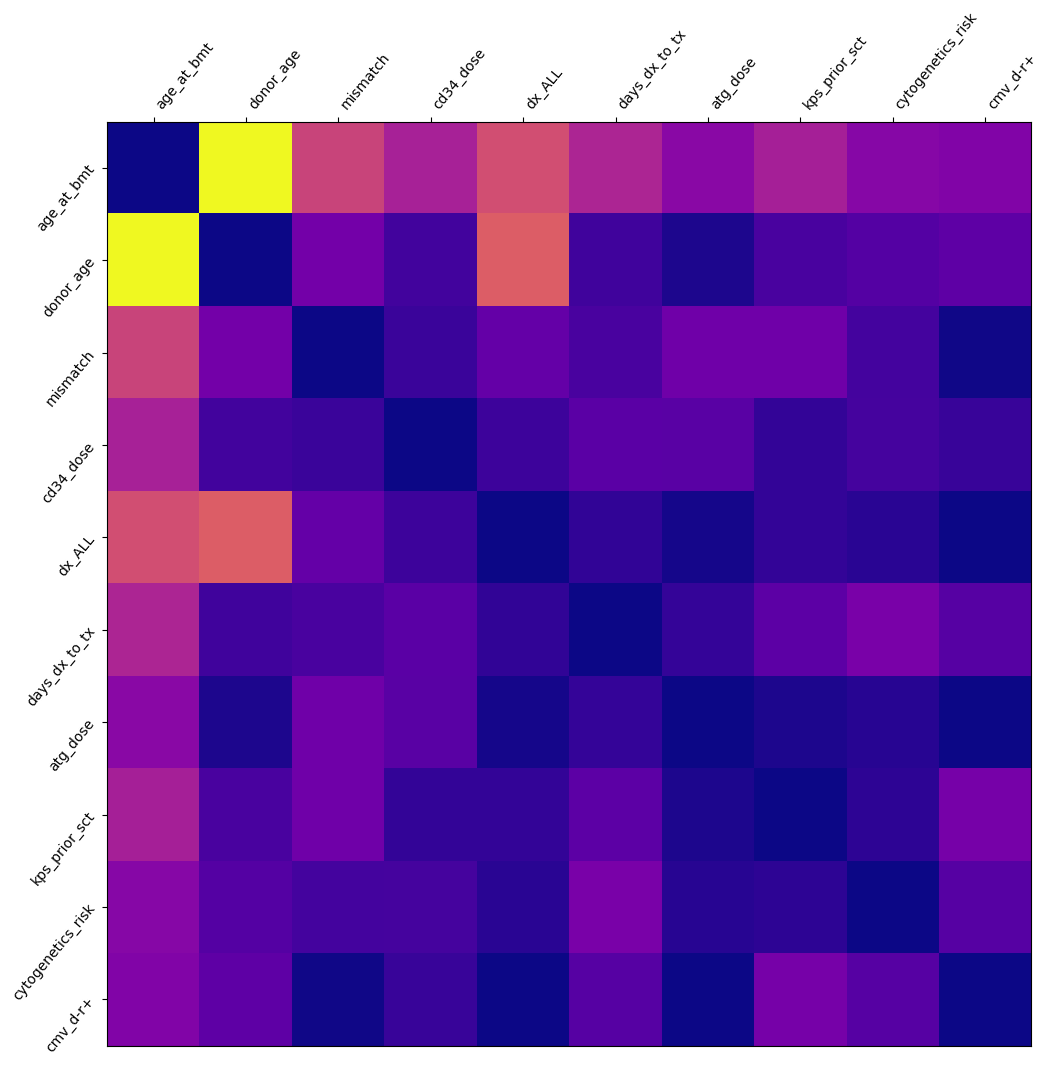

In [10]:
#Interaction Matrix for top 10 features

tmp = np.abs(shap_interaction_values_al).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:10]
tmp2 = tmp[inds, :][:, inds]
plt.figure(figsize=(12, 12))
plt.imshow(tmp2, cmap = 'plasma')

plt.yticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right"
)
plt.xticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left"
)
plt.gca().xaxis.tick_top()
plt.savefig('matrix_al.png')
plt.show()


<Figure size 5120x3840 with 0 Axes>

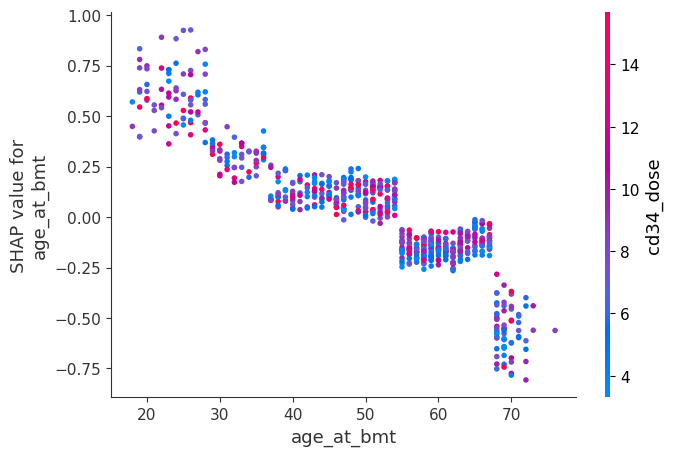

In [11]:
plot_shap_dependence_pairs('age_at_bmt', 'cd34_dose', shap_values_al, al)


<Figure size 5120x3840 with 0 Axes>

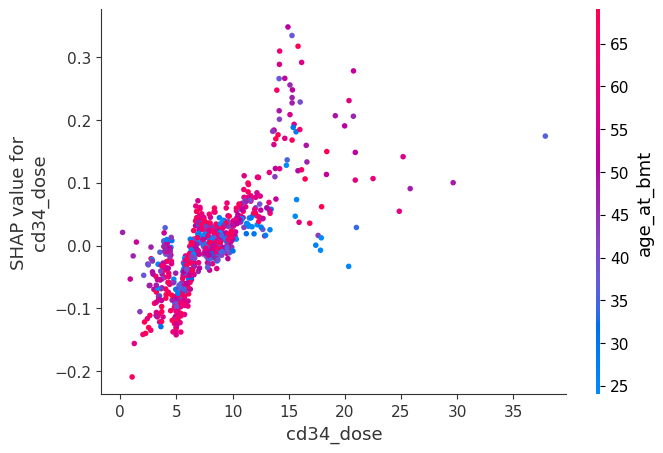

In [12]:

plot_shap_dependence_pairs('cd34_dose', 'age_at_bmt', shap_values_al, al)


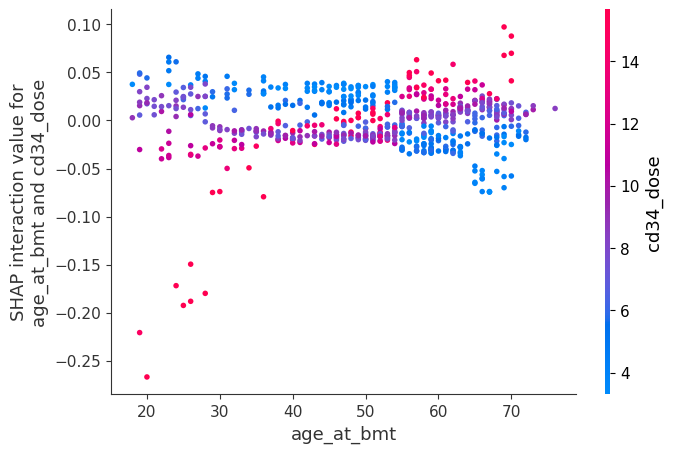

In [13]:
shap.dependence_plot(
    
    ("age_at_bmt","cd34_dose"),
    shap_interaction_values_al, al
)

#### Force Plots of different scenarios for AL

In [14]:
# load JS visualization code to notebook
shap.initjs()
shap_values_al = explainer_new(al)


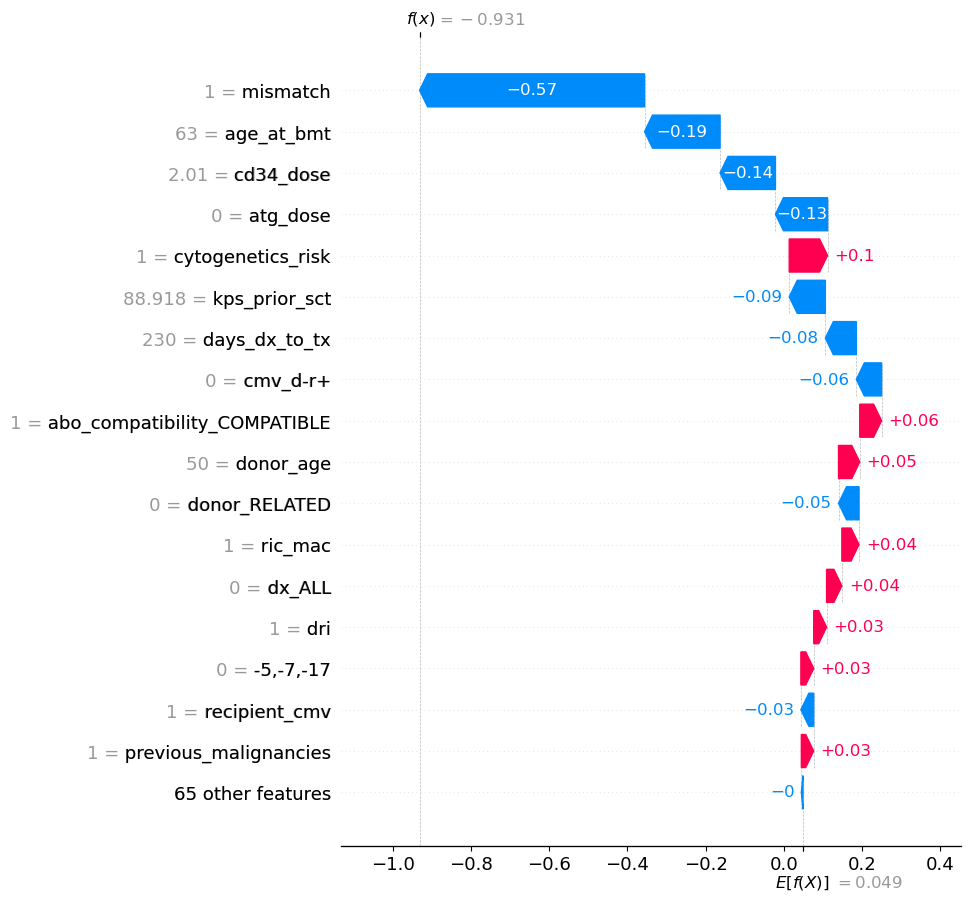

In [15]:
# visualize old patient with low dose of CD34
shap.plots.waterfall(shap_values_al[9], max_display = 18)

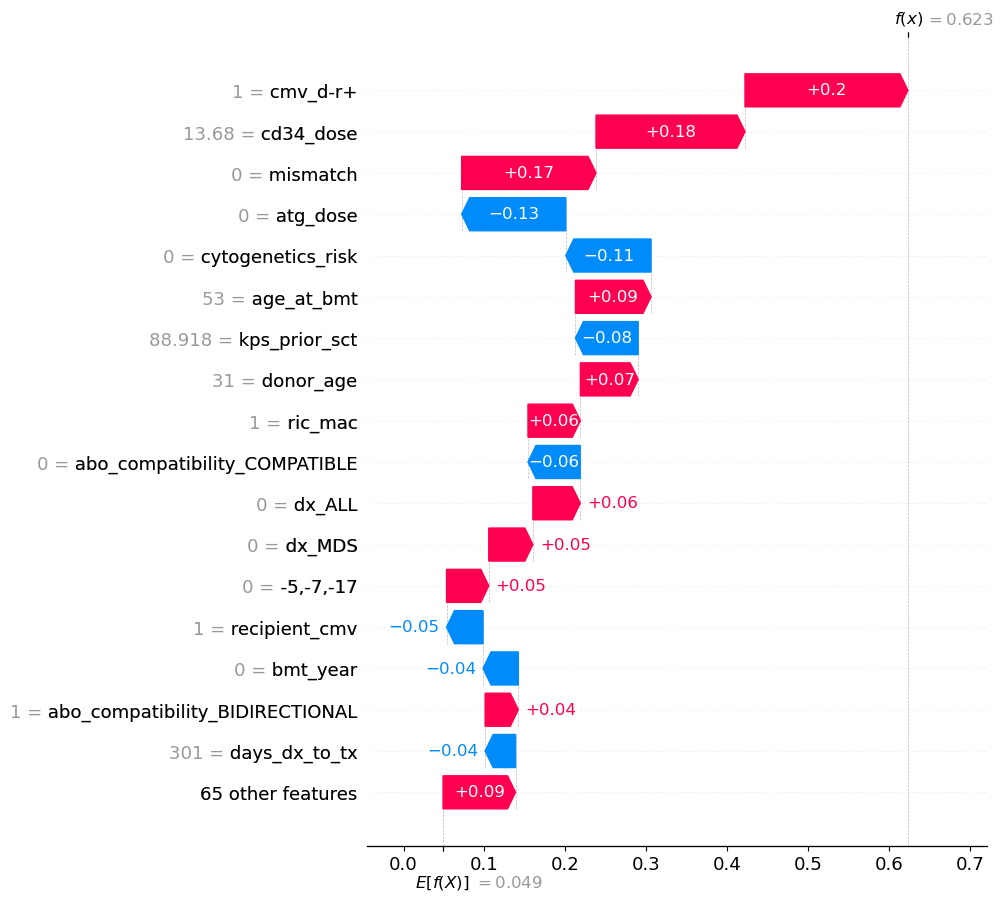

In [16]:
# visualize old patient with high dose of CD34
shap.plots.waterfall(shap_values_al[25], max_display= 18)

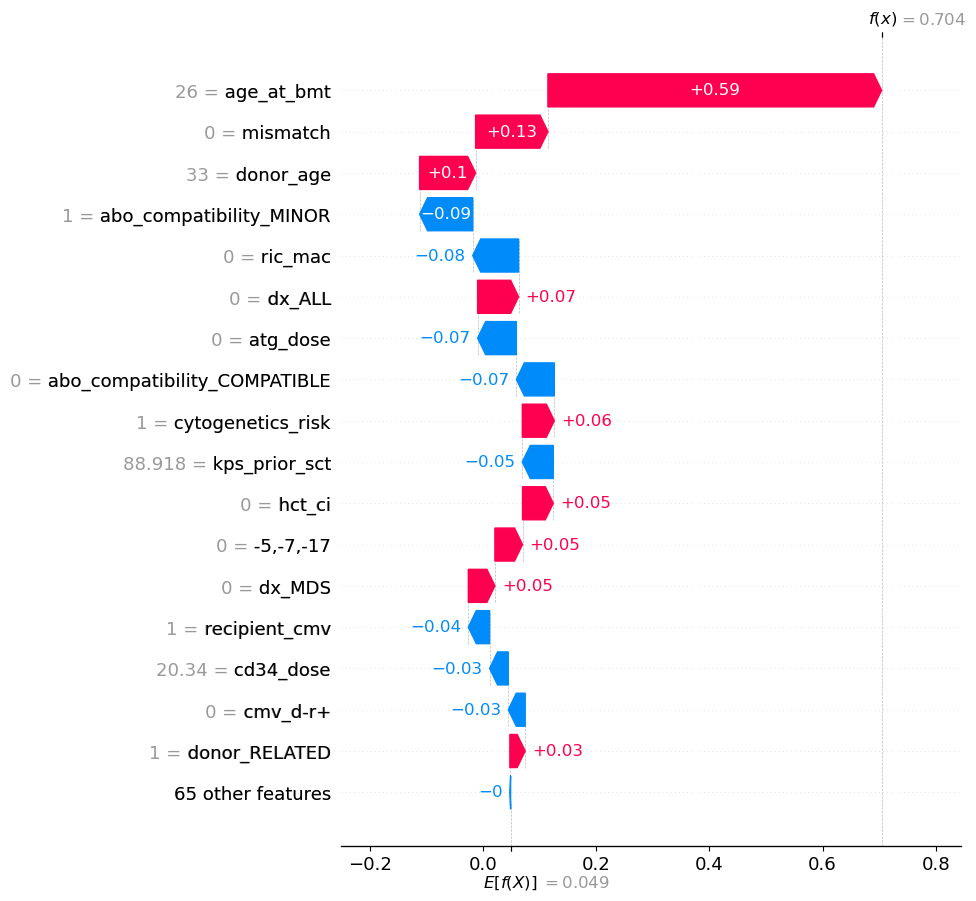

In [17]:
# visualize young patient with high dose of CD34
shap.plots.waterfall(shap_values_al[145], max_display= 18)

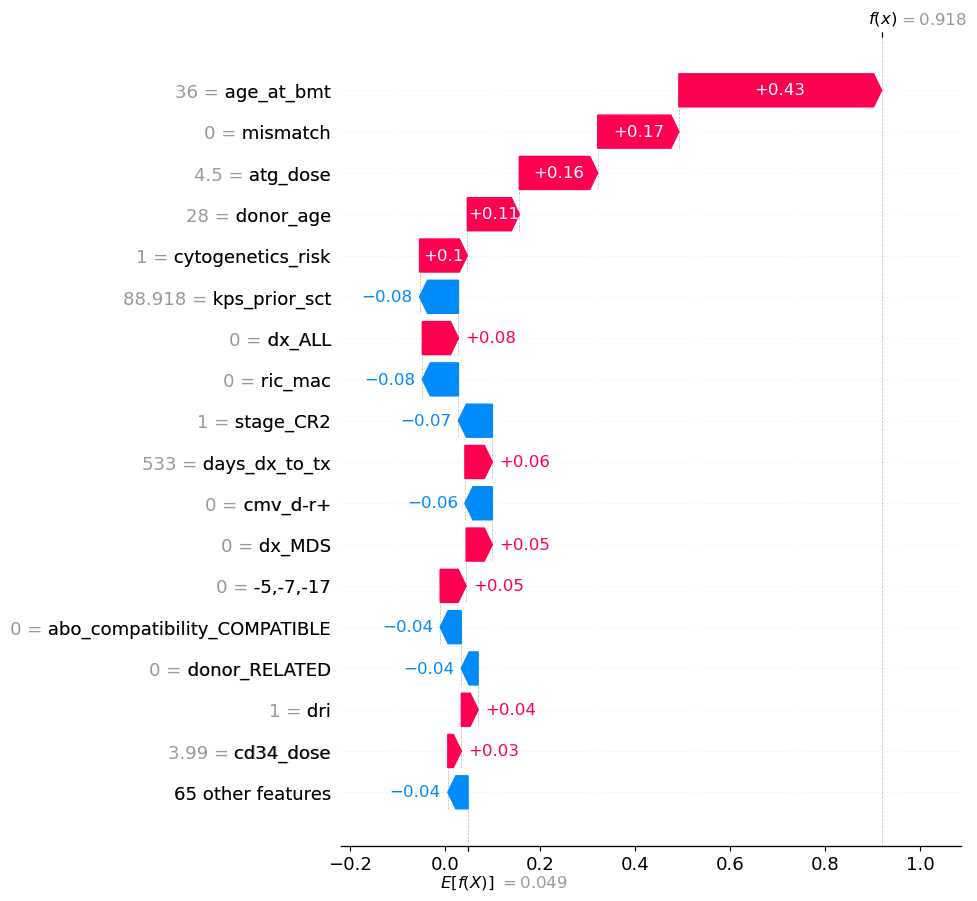

In [18]:
# visualize young patient with low dose of CD34
shap.plots.waterfall(shap_values_al[42], max_display= 18)

### Lymphoma Investigation

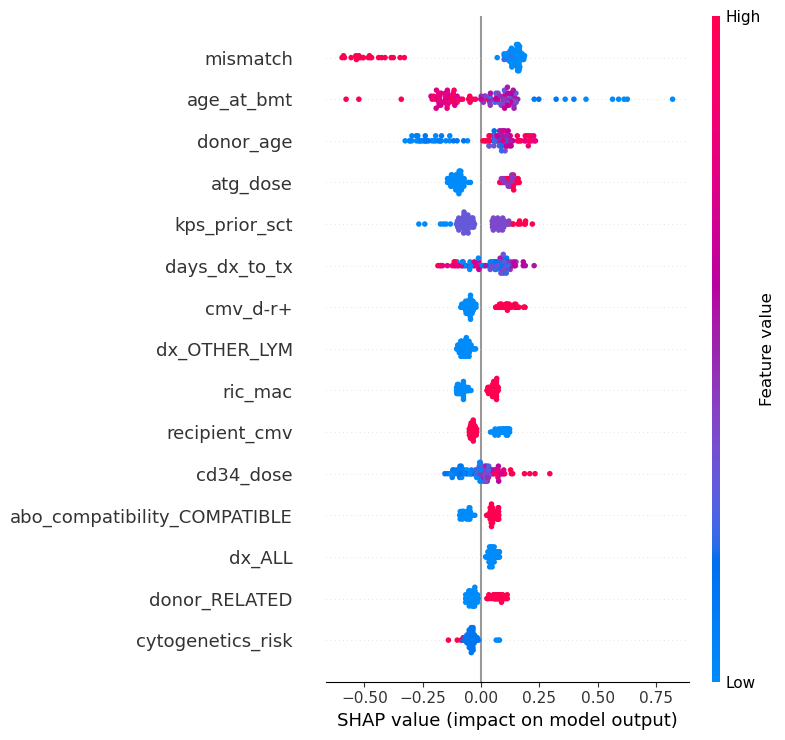

In [19]:
#Summary plot of top 15 features

shap.summary_plot(shap_values_lym, lym, max_display=15)

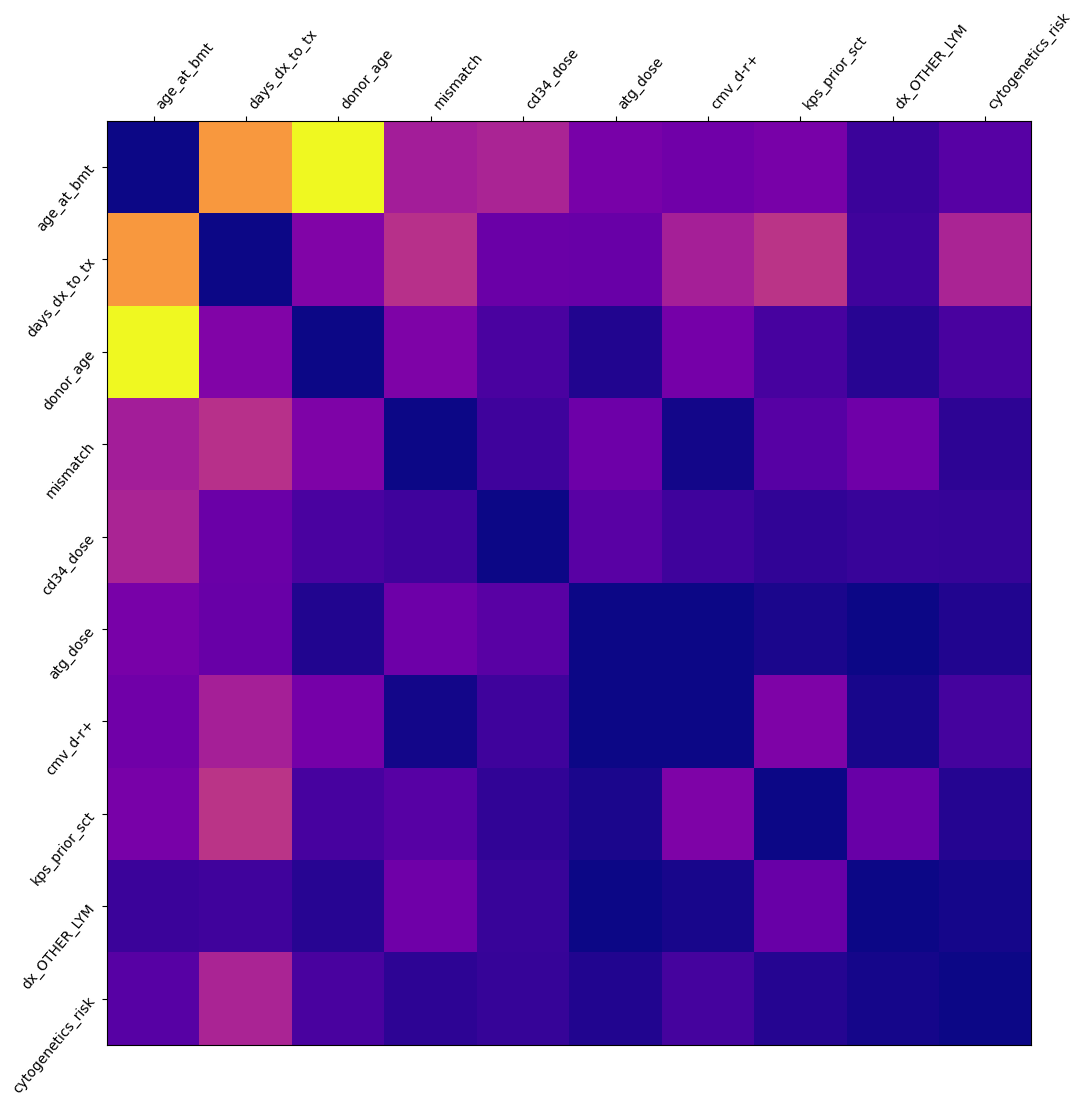

In [20]:
#Interaction Matrix for top 10 features

tmp = np.abs(shap_interaction_values_lym).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:10]
tmp2 = tmp[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(tmp2, cmap = 'plasma')

pl.yticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right"
)
pl.xticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left"
)
pl.gca().xaxis.tick_top()
pl.show()

### MDS Investigation

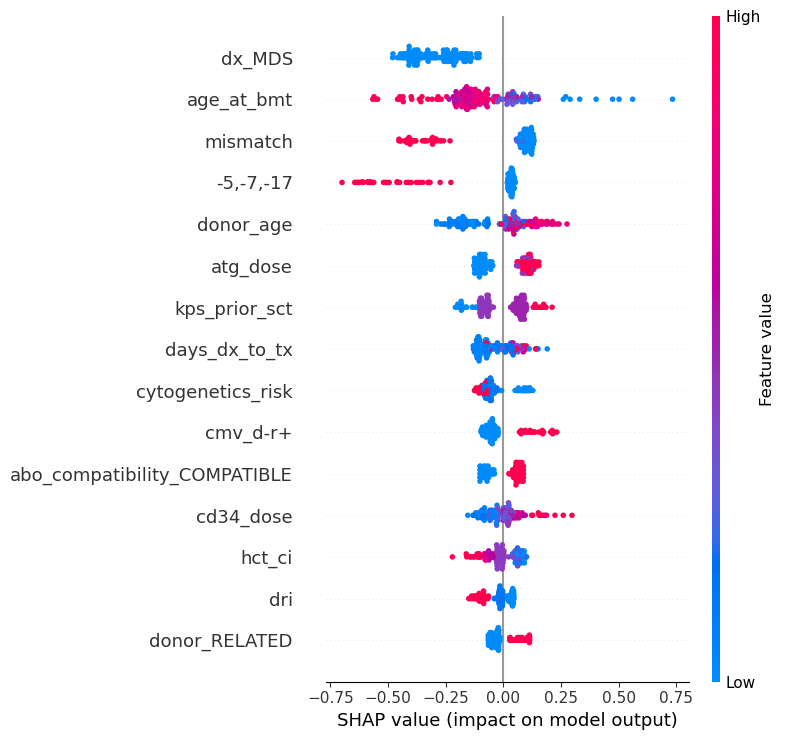

In [21]:
#Summary plot of top 15 features

shap.summary_plot(shap_values_mds, mds, max_display=15)

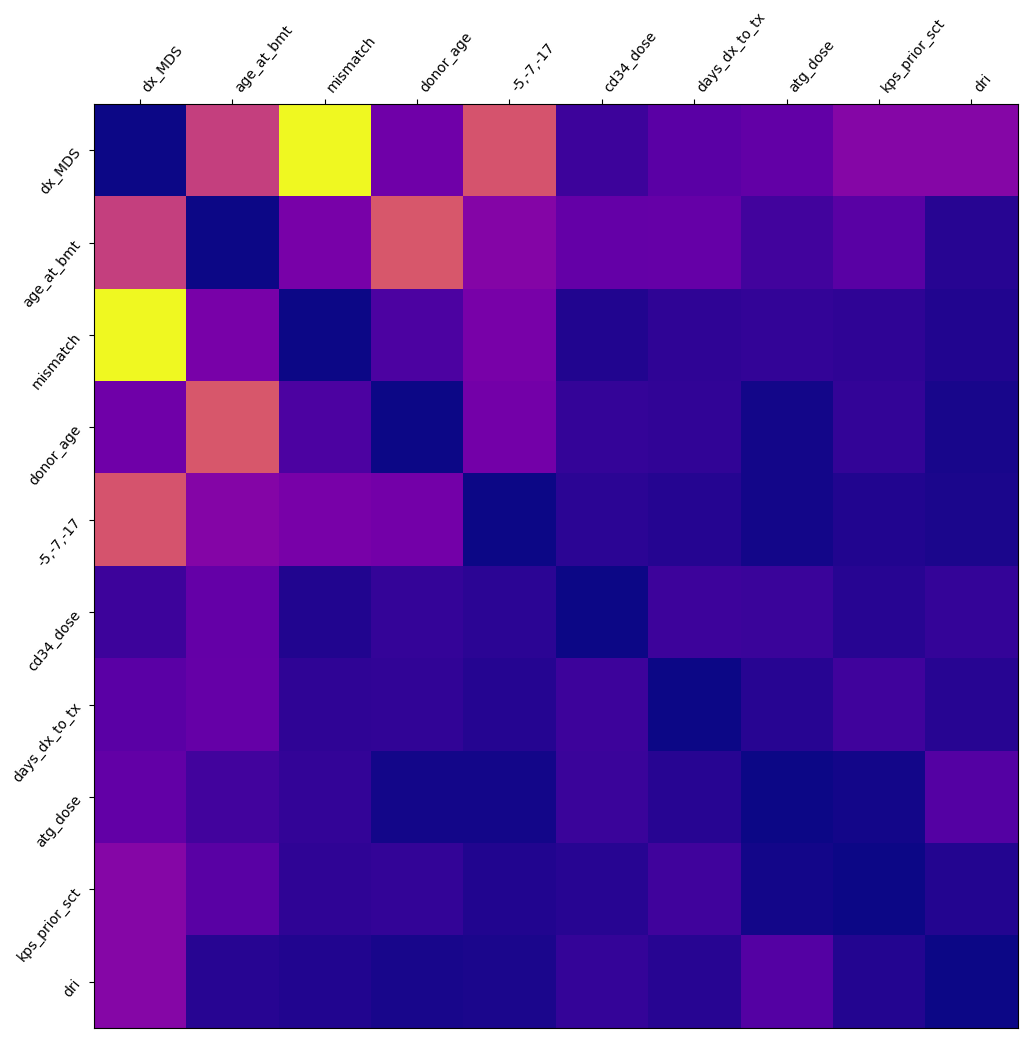

In [22]:
#Interaction Matrix for top 10 features

tmp = np.abs(shap_interaction_values_mds).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:10]
tmp2 = tmp[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(tmp2, cmap = 'plasma')

pl.yticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right"
)
pl.xticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left"
)
pl.gca().xaxis.tick_top()
pl.show()

### MM Investigation

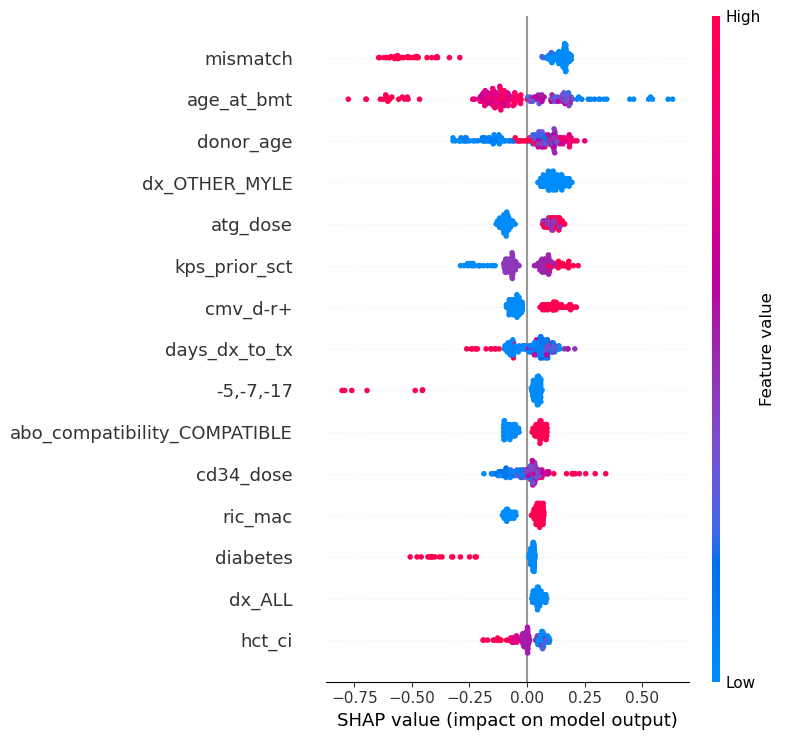

In [23]:
#Summary plot of top 15 features

shap.summary_plot(shap_values_myle, myle, max_display=15)

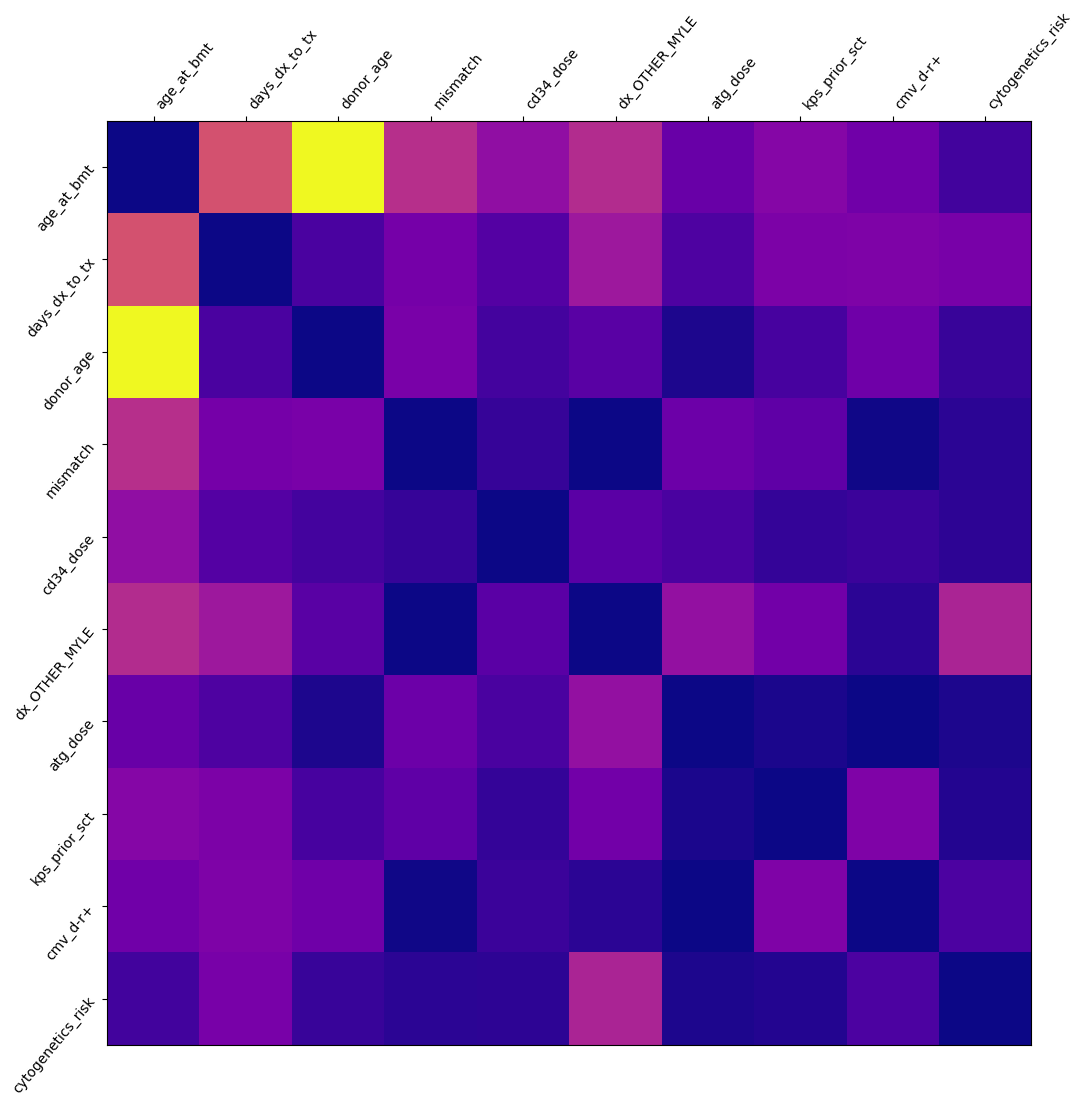

In [24]:
#Interaction Matrix for top 10 features

tmp = np.abs(shap_interaction_values_myle).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:10]
tmp2 = tmp[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(tmp2, cmap = 'plasma')

pl.yticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right"
)
pl.xticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left"
)
pl.gca().xaxis.tick_top()
pl.show()

### Others Investigation

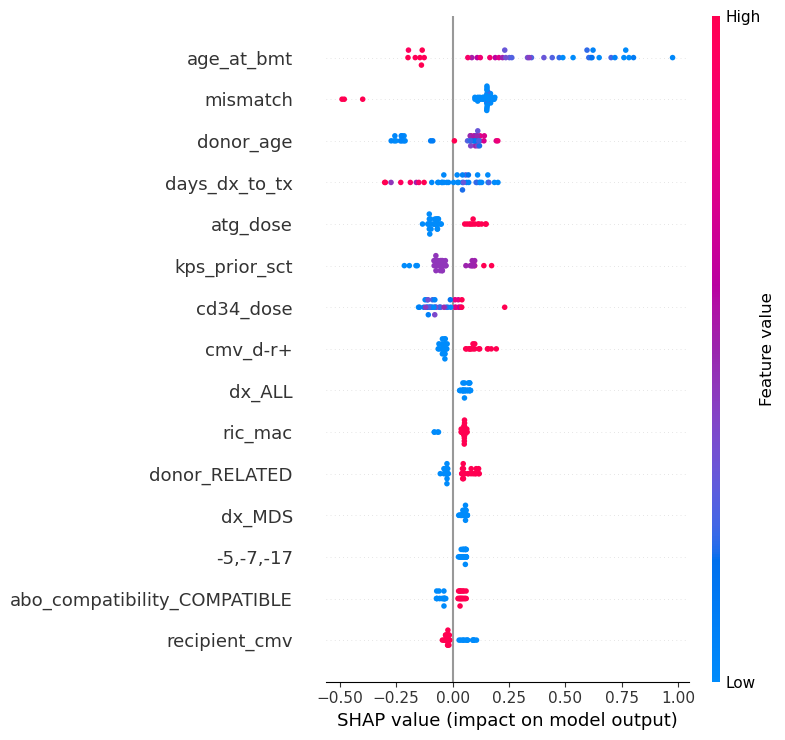

In [25]:
#Summary plot of top 15 features

shap.summary_plot(shap_values_other, other, max_display=15)

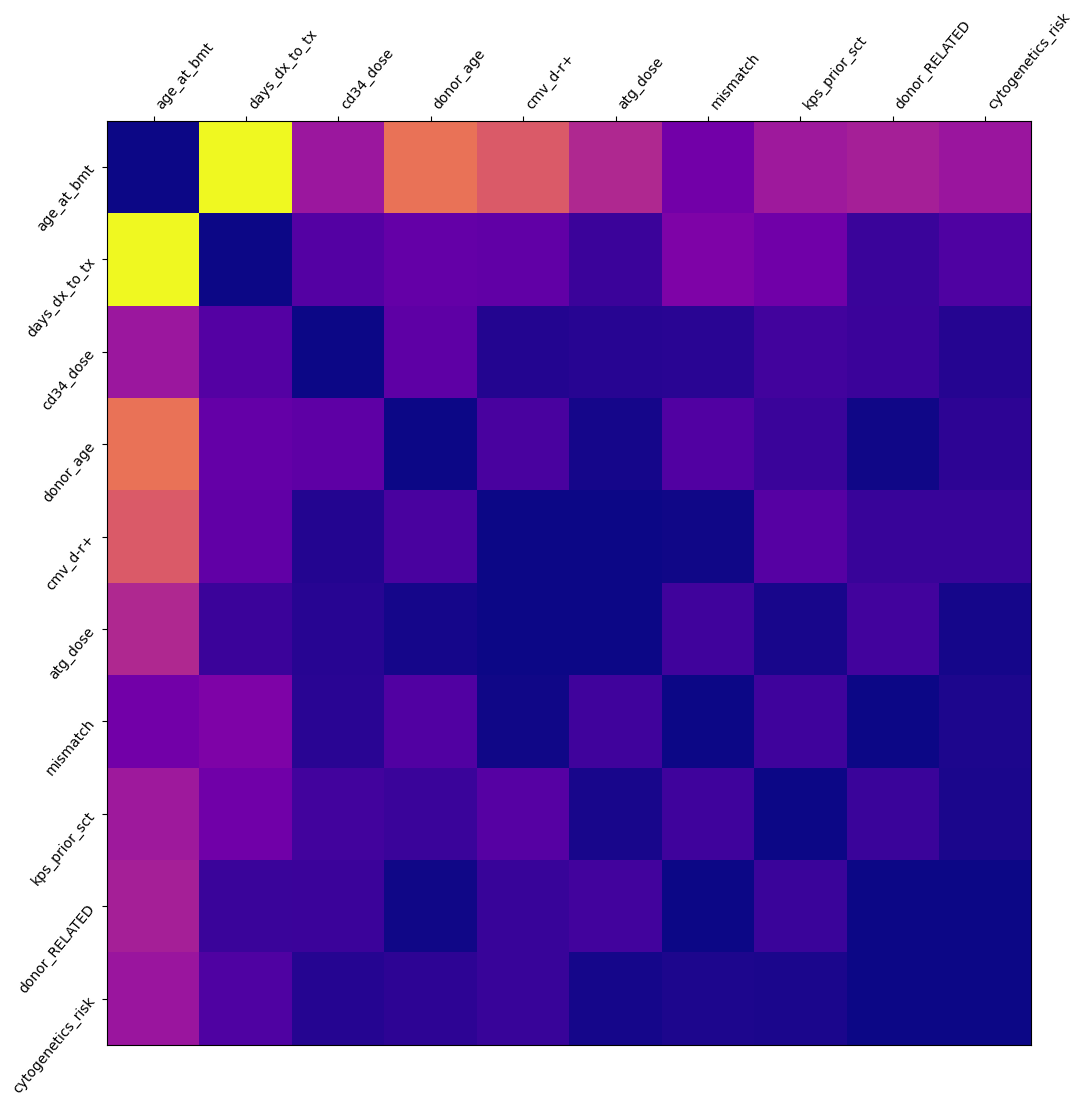

In [26]:
#Interaction Matrix for top 10 features

tmp = np.abs(shap_interaction_values_other).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:10]
tmp2 = tmp[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(tmp2, cmap = 'plasma')

pl.yticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right"
)
pl.xticks(
    range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left"
)
pl.gca().xaxis.tick_top()
pl.show()